In [1]:
import data, model, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch.utils.tensorboard as tb
import torchvision

%load_ext autoreload
%autoreload 2

In [2]:
tb_writer = tb.SummaryWriter('log')

In [3]:
VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 64
CHANNELS = 3
STYLE_DIM = 256
CONTENT_DIM = 1024
BATCH_SIZE = 1
#CONTENT_LOSS_WEIGHTS = {'input' : 0.0, 'relu3' : 0.0, 'relu4' : 1e2, 'relu5' : 0.0}
#STYLE_LOSS_WEIGHTS = {'input' : 0.0, 'relu1' : 1e2, 'relu2' : 1e2, 'relu3' : 1e2, 'relu4' : 1e2, 'relu5' : 1e2}

CONTENT_LOSS_WEIGHTS = {
    'relu_1_1' : 1e0,
    'relu_4_2' : 1e0,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e-3,
    'relu_2_1' : 1e-3,
    'relu_3_1' : 1e-3,
    'relu_4_1' : 1e-3,
    'relu_5_1' : 1e-3,
}

In [4]:
def forward(content, style, content_encoder, style_encoder, decoder):
    """ Forwards a batch through the pipeline.
    
    Parameters:
    -----------
    content : torch.Tensor, shape [B, C, H, W]
        The content image.
    style : torch.Tensor, shape [B, C, H', W']
        The style image, usually H' = H and W' = W.
    content_encoder : torch.nn.modules.Module
        Encoder for content images.
    style_encoder : torch.nn.modules.Module
        Encoder for style images.
    decoder : torch.nn.modules.Module
        Decoder that uses AdaIn to decode the content and apply the style.

    Returns:
    --------
    reco : torch.Tensor, shape [B, C, H, W]
        A reconstruction of the content after application of the style.
    content_representation : torch.Tensor, shape [B, D]
        Content representation.
    style_representation : torch.Tensor, shape [B, D']
        The latent style representation.
    """
    content_representation = content_encoder(content)
    style_representation = style_encoder(style)
    #transformed_content = function.adain(content_representation, style_representation)
    #print(content_representation.shape)
    #print(style_representation.shape)
    reco = decoder(content_representation, style_representation)
    #reco = decoder(content_representation)
    return reco, content_representation, style_representation

def print_content_feature_contrib(feature_activations_x, feature_activations_y):
    for key in feature_activations_x:
        feature_loss = torch.nn.functional.mse_loss(feature_activations_x[key], feature_activations_y[key])
        weight = 0.0
        if key in CONTENT_LOSS_WEIGHTS:
            weight = CONTENT_LOSS_WEIGHTS[key]
        weighted_loss = weight * feature_loss
        print("Content layer {} loss: {} weight: {} weighted loss: {}".format(key, feature_loss, weight, weighted_loss))

def print_style_feature_contrib(features_style, features_transformed):
    for key, weight in STYLE_LOSS_WEIGHTS.items():
        Gx = function.gram_matrix(features_style[key])
        Gy = function.gram_matrix(features_transformed[key])
        value = torch.nn.functional.mse_loss(Gx, Gy)
        weighted_value = weight * value
        print(f'Style loss {key} with weight {weight}: {value} weighted loss: {weighted_value}')

In [5]:
data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

data_content = data.load_debug_dataset('../dataset/content', resolution=RESOLUTION)
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

In [6]:
#content_encoder = model.ResNetEncoder(CONTENT_DIM, architecture=torchvision.models.resnet34)
#style_encoder = model.ResNetEncoder(STYLE_DIM, architecture=torchvision.models.resnet18)
#decoder = model.Decoder(CONTENT_DIM, STYLE_DIM, (RESOLUTION, RESOLUTION))

#content_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION), flattened_output_dim=CONTENT_DIM)
#style_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION), flattened_output_dim=STYLE_DIM)
#decoder = model.VGGDecoder((CHANNELS, RESOLUTION, RESOLUTION), STYLE_DIM, CONTENT_DIM)

content_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION))
style_encoder = model.VGGEncoder((CHANNELS, RESOLUTION, RESOLUTION))
decoder = model.VGGDecoder((CHANNELS, RESOLUTION, RESOLUTION), STYLE_DIM, None)

loss_net = loss.LossNet()
_ = loss_net.eval()

In [7]:
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in content_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in decoder.parameters():
    trainable_parameters.append(parameter)

In [8]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-3)

# Overfitting
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    content_image, style_image = content_image[:1], style_image[:1]
    break
content_encoder.train()
style_encoder.train()
decoder.train()
if torch.cuda.is_available():
    content_image = content_image.to('cuda')
    style_image = style_image.to('cuda')
for iteration in range(ITERATIONS):
    optimizer.zero_grad()
    
    stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
    total_loss = perceptual_loss + style_loss
    total_loss.backward()
    optimizer.step()

    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        tb_writer.add_images('images', torch.from_numpy(np.concatenate([
            data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        ])), iteration)

    0 / 15002: loss : 34.9655 -- perceptual loss : 34.9655 -- style loss : 0.0000
Validation...


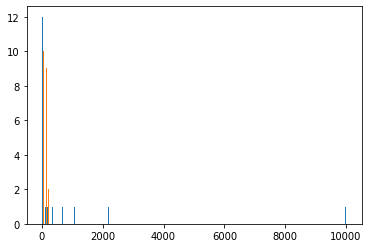

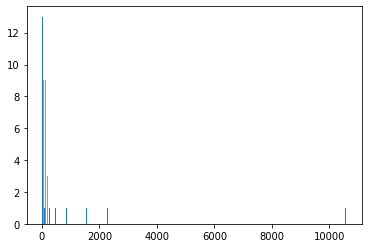

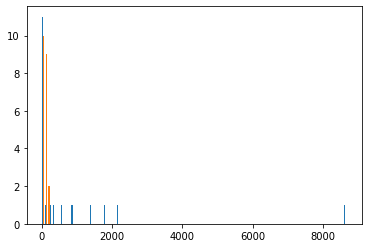

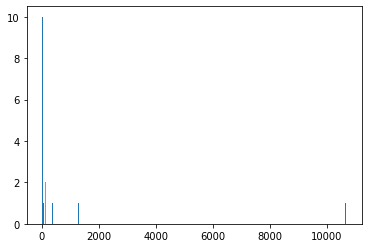

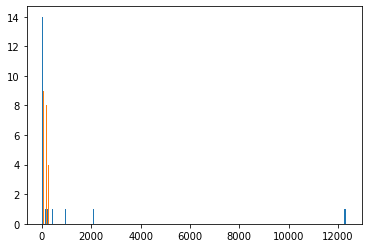

    5 / 5: loss : 19.5296 -- perceptual loss : 19.5296 -- style loss : 0.0000
Training...
  500 / 15002: loss : 8.4697 -- perceptual loss : 8.4697 -- style loss : 0.000000
Validation...


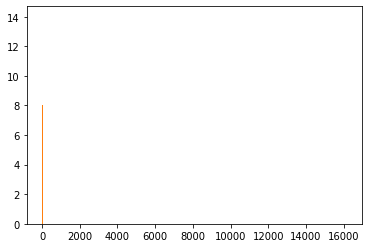

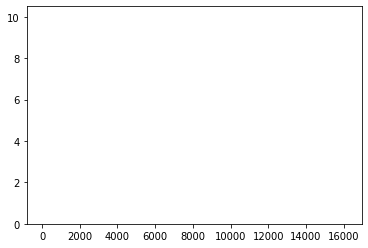

In [ ]:
iteration = 0
val_step = 0
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: 
        break
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')
    
    content_encoder.train(), style_encoder.train(), decoder.train()
    optimizer.zero_grad()
    
    stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
    total_loss = perceptual_loss + style_loss
    total_loss.backward()
    optimizer.step()
    
    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    if iteration % 500 == 0:
        #tb_writer.add_images('train images', torch.from_numpy(np.concatenate([
        #    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        #])), iteration)
        # Validate
        print('\nValidation...')
        with torch.no_grad():
            val_iteration = 0
            content_encoder.eval(), style_encoder.eval(), decoder.eval()
            for (content_image, content_path), (style_image, style_path) in data_loader_train:
                if val_iteration >= VAL_ITERATIONS:
                    print('\nTraining...')
                    break
                    
                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')
                stylized, content_encoding, style_encoding = forward(content_image, style_image, content_encoder, style_encoder, decoder)
                
                torch.set_printoptions(profile="full")
                #print(content_encoding)
                torch.set_printoptions(profile="default")
    
                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_stylized = loss_net(stylized)

                perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS)
                style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS)
                total_loss = perceptual_loss + style_loss
                
                content_hist = np.histogram(content_encoding.detach().cpu().numpy(), bins=20)
                plt.hist(content_hist, bins='auto')
                plt.show()

                #tb_writer.add_histogram('embedding distribution', content_encoding.detach().cpu().numpy(), val_step, bins=1000)
                tb_writer.add_scalar('validation loss', total_loss.item(), val_step)
                tb_writer.add_scalar('validation perceptual loss', perceptual_loss.item(), val_step)
                tb_writer.add_scalar('validation style loss', style_loss.item(), val_step)
                tb_writer.add_images('validation images', torch.from_numpy(np.concatenate([
                    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
                ])), val_step)
                val_iteration += 1
                val_step += 1
                print(f'\r{val_iteration:5d} / {VAL_ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    iteration += 1
    
    

# Old Training Loop

In [ ]:


optimizer = torch.optim.Adam(trainable_parameters, lr=1e-6)


iteration = 0
running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0

content_loss_history_train = []
style_loss_history_train = []
content_loss_history_val = []
style_loss_history_val = []

for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: break
    iteration += 1
    
    content_encoder.train()
    style_encoder.train()
    decoder.train()

    optimizer.zero_grad()
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')

    #content_representation = content_encoder(content_image)
    #style_representation = style_encoder(style_image)

    #transformed_content = function.adain(content_representation, style_representation)
    #transformed = decoder(transformed_content)
    #transformed = decoder(content_representation, style_representation)
    
    transformed, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_transformed = loss_net(transformed)

    perceptual_loss = loss.perceptual_loss(features_content, features_transformed, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_transformed, STYLE_LOSS_WEIGHTS)
    
    lambda_content = 1.0
    lambda_style = 1.0

    total_loss = lambda_content * perceptual_loss + lambda_style * style_loss

    total_loss.backward()
    optimizer.step()

    running_perceptual_loss += perceptual_loss.item()
    running_style_loss += style_loss.item()

    running_count += 1

    print(f'\r{iteration:06d} : avg perceptual_loss : {running_perceptual_loss / running_count:.4f}\tavg style loss : {running_style_loss / running_count:.4f}', end='\r')
    content_loss_history_train.append(perceptual_loss.item())
    style_loss_history_train.append(style_loss.item())
    
    if iteration % 5000 == 1:
        torch.save(content_encoder.state_dict(), f'output/content_encoder_{iteration}')
        torch.save(style_encoder.state_dict(), f'output/style_encoder_{iteration}')
        torch.save(decoder.state_dict(), f'output/decoder_{iteration}')

    if iteration % 500 == 1:

        running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0 # After each validation, reset running training losses
        print(f'\nValidating...')

        content_encoder.eval()
        style_encoder.eval()
        decoder.eval()
        perceptual_loss = 0.0
        style_loss = 0.0
        val_iteration = 0

        with torch.no_grad():

            torch.save(content_image.cpu(), f'output/{iteration}_0_content.pt')
            torch.save(style_image.cpu(), f'output/{iteration}_0_style.pt')
            #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_0_style_reconstructed.pt')
            #torch.save(decoder(content_representation).cpu(), f'output/{iteration}_0_reconstructed.pt')
            torch.save(transformed.cpu(), f'output/{iteration}_0_transformed.pt')


            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                val_iteration += 1
                if val_iteration > VAL_ITERATIONS: break

                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')

                #content_representation = content_encoder(content_image)
                #style_representation = style_encoder(style_image)

                #transformed_content = function.adain(content_representation, style_representation)
                #reconstruction = decoder(transformed_content)
                #reconstruction = decoder(content_representation, style_representation)
                
                reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_reconstruction = loss_net(reconstruction)
                
                print("------------------------------------------------------------------")
                print("Features content:")
                print_content_feature_contrib(features_content, features_reconstruction)
                print("Features style:")
                print_style_feature_contrib(features_style, features_reconstruction)
                print("------------------------------------------------------------------")
                
                perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
                style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)
                    
                torch.save(content_image.cpu(), f'output/{iteration}_{val_iteration}_content.pt')
                torch.save(style_image.cpu(), f'output/{iteration}_{val_iteration}_style.pt')
                torch.save(reconstruction.cpu(), f'output/{iteration}_{val_iteration}_reconstruction.pt')
                #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_{val_iteration}_style_reconstruction.pt')

                print(f'\rValidation {val_iteration:02d} : Perceptual loss {perceptual_loss / val_iteration:.4f}\tStyle loss {style_loss / val_iteration:.4f}', end='\r')
            print('\nValidation done.')
            val_iteration -= 1
            content_loss_history_val.append((iteration, perceptual_loss / val_iteration))
            style_loss_history_val.append((iteration, style_loss / val_iteration))

            torch.save(content_loss_history_train, 'output/content_loss_history_train.pt')
            torch.save(style_loss_history_train, 'output/style_loss_history_train.pt')
            torch.save(content_loss_history_val, 'output/content_loss_history_val.pt')
            torch.save(style_loss_history_val, 'output/style_loss_history_val.pt')
            

# Evaluate

In [11]:
CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 5e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}
RESOLUTION = 256
ITERATION = 5001
EVAL_ITERATIONS = 1
BATCH_SIZE = 1

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_loader_style_eval = DataLoader(data_style, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_loader_content_eval = DataLoader(data_content, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_loader_eval = data.DatasetPairIterator(data_loader_content_eval, data_loader_style_eval)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

content_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/content_encoder_{ITERATION}'))
style_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/style_encoder_{ITERATION}'))
decoder.load_state_dict(torch.load(f'output_train_places365_starry_night/decoder_{ITERATION}'))

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

content_encoder.eval()
style_encoder.eval()
decoder.eval()

with torch.no_grad():
    eval_iteration = 0

    for (content_image, content_path), (style_image, style_path) in data_loader_eval:
        if eval_iteration >= EVAL_ITERATIONS:
            break

        perceptual_loss = 0.0
        style_loss = 0.0
        eval_iteration += 1

        if torch.cuda.is_available():
            content_image = content_image.to('cuda')
            style_image = style_image.to('cuda')

        #content_representation = content_encoder(content_image)
        #style_representation = style_encoder(style_image)

        #transformed_content = function.adain(content_representation, style_representation)
        #reconstruction = decoder(transformed_content)
        #reconstruction = decoder(content_representation, style_representation)

        reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

        features_content = loss_net(content_image)
        features_style = loss_net(style_image)
        features_reconstruction = loss_net(reconstruction)

        perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
        style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)

        torch.save(content_image.cpu(), f'output/eval_{eval_iteration}_content.pt')
        torch.save(style_image.cpu(), f'output/eval_{eval_iteration}_style.pt')
        torch.save(reconstruction.cpu(), f'output/eval_{eval_iteration}_reconstruction.pt')

        print(f'Evaluation {eval_iteration:02d} : Perceptual loss {perceptual_loss:.4f}\tStyle loss {style_loss:.4f}')


Evaluation 01 : Perceptual loss 0.4050	Style loss 0.0529


# Other

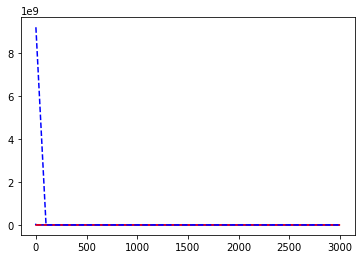

In [5]:
plt.plot(content_loss_history_train[10:], "r")
plt.plot(style_loss_history_train[10:], "b")
plt.plot(*zip(*content_loss_history_val), "r--")
plt.plot(*zip(*style_loss_history_val), "b--")

In [ ]:
image_batch = torch.load("./output/91_9_reconstruction.pt")
image_batch = data.vgg_normalization_undo(image_batch.numpy())
#plt.imshow(transforms.ToPILImage()(image))
image_batch = np.transpose(image_batch, (0, 2, 3, 1))
plt.imshow(image_batch[0])

In [6]:
def show_images(epoch, iteration):
    content_batch = torch.load("./output/{}_{}_content.pt".format(epoch, iteration))
    style_batch = torch.load("./output/{}_{}_style.pt".format(epoch, iteration))
    reconstruction_batch = torch.load("./output/{}_{}_reconstruction.pt".format(epoch, iteration))
    
    content_batch = data.vgg_normalization_undo(content_batch.numpy())
    style_batch = data.vgg_normalization_undo(style_batch.numpy())
    reconstruction_batch = data.vgg_normalization_undo(reconstruction_batch.numpy())
    
    content_batch = np.transpose(content_batch, (0, 2, 3, 1))
    style_batch = np.transpose(style_batch, (0, 2, 3, 1))
    reconstruction_batch = np.transpose(reconstruction_batch, (0, 2, 3, 1))
    
    fig = plt.figure(figsize=(12, 4))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(content_batch[0])
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(style_batch[0])
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(reconstruction_batch[0])

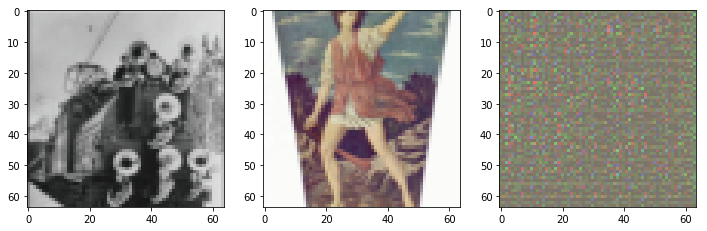

In [11]:
show_images(1, 1)

In [16]:
print(STYLE_DIM)

2310
